In [54]:
import json
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from data.graph_loader import load_graph
%matplotlib inline

print(f'Loading ratings')
mr = pd.read_csv('../data/mindreader/ratings.csv')

# Remove unknown ratings
mr = mr[mr.sentiment != 0]

# Load entities
entities = dict()
with open('../data/mindreader/entities_clean.json', 'r') as file:
    data = json.load(file)
    
    for uri, name, labels in data:
        entities[uri] = set(labels.split('|'))

# Load NX graph
print(f'Loading graph')
g = load_graph('../data/graph/triples.csv', directed=True)

Loading ratings
Loading graph


In [55]:
def _propagate(node, preferences, preference):
    for neighbor in g.neighbors(node):
        preferences[neighbor].append(preference)
        
        # _propagate(neighbor, preferences, preference * 0.5)
            

def propagate(movie_preferences):
    preferences = defaultdict(list)
    
    for movie, preference in movie_preferences.items():
        _propagate(movie, preferences, preference)
            
    return preferences


def reduce_preferences(preferences):
    reduced = dict()
    
    # Reduces preferences from a list of ratings to its majority vote
    for uri, preference_list in preferences.items():
        mean = np.mean(preference_list)
        variance = np.var(preference_list)
        
        prediction = 0 if mean == 0. or variance > 0.85 else 1 if mean > 0 else -1
        if prediction:
            reduced[uri] = prediction
    
    return reduced


def infer_preferences(ratings, user):
    user_ratings = ratings[ratings.userId == user][['uri', 'sentiment', 'isItem']]
    entity_preferences = dict()
    movie_preferences = dict()
    
    for idx, row in user_ratings[user_ratings.isItem].iterrows():
        movie_preferences[row['uri']] = row['sentiment']
        
    for idx, row in user_ratings[~user_ratings.isItem].iterrows():
        entity_preferences[row['uri']] = row['sentiment']
    
    return reduce_preferences(propagate(movie_preferences)), entity_preferences


def predict(user, uris=None):
    predicted, actual = infer_preferences(mr, user)
    overlapping = set(predicted.keys()).intersection(set(actual.keys()))
    tp, fp, tn, fn = [0 for _ in range(4)]

    for key in overlapping:
        if uris and key not in uris:
            continue
        
        if actual[key] == 1 and predicted[key] == 1:
            tp += 1
        elif actual[key] == -1 and predicted[key] == 1:
            fp += 1
        elif actual[key] == -1 and predicted[key] == -1:
            tn += 1
        elif actual[key] == 1 and predicted[key] == -1:
            fn += 1
    
    return tp, fp, tn, fn


def get_metrics(df, uris=None):
    users = df.userId.unique()
    total_tp, total_fp, total_tn, total_fn = [0 for _ in range(4)]
    
    for user in tqdm(users):
        tp, fp, tn, fn = predict(user, uris=uris)
        
        total_tp += tp
        total_fp += fp
        total_tn += tn
        total_fn += fn
    
    precision = total_tp / (total_tp + total_fp)
    recall = total_tp / (total_tp + total_fn)
    true_negative = total_tn / (total_tn + total_fp)
    accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn)
    f1 = (2 * precision * recall) / (precision + recall)
    
    return precision, recall, true_negative, f1, accuracy


def print_metrics(precision, recall, true_negative, f1, accuracy):
    print(f'Precision: {precision * 100}%')
    print(f'Recall: {recall * 100}%')
    print(f'True negative rate: {true_negative * 100}%')
    print(f'F1: {f1 * 100}%')
    print(f'Accuracy: {accuracy * 100}%')

In [56]:
splits = {
    'All': None,
    'Genre': {'Genre'},
    'Subject': {'Subject'},
    'Person': {'Person'},
    'Studio': {'Company'},
    'Decade': {'Decade'}
}

def get_valid_uris(restrict_to=None):
    if not restrict_to:
        return set(entities.keys())
    
    return {e for e, l in entities.items() if not restrict_to or l.intersection(restrict_to)}

results = dict()
for split, restriction in splits.items():
    results[split] = get_metrics(mr, get_valid_uris(restriction))
    
    print(split)
    print(print_metrics(*results[split]))

100%|██████████| 1899/1899 [03:10<00:00,  9.99it/s]


All
Precision: 90.7478986440886%
Recall: 82.96499887816917%
True negative rate: 61.569826707441386%
F1: 86.68209921762828%
Accuracy: 79.10536962118427%
None
Genre
Precision: 89.52738990332976%
Recall: 85.70694087403598%
True negative rate: 57.63172189027702%
F1: 87.57551878119254%
Accuracy: 80.33468454422618%
None
Subject
Precision: 82.96337402885683%
Recall: 83.80044843049326%
True negative rate: 57.53803596127247%
F1: 83.37981037367541%
Accuracy: 76.22656561627443%
None
Person
Precision: 91.48430066603235%
Recall: 78.28210869122736%
True negative rate: 66.94367497691599%
F1: 84.36985850608754%
Accuracy: 76.23415610406938%
None
Studio
Precision: 95.56036816459122%
Recall: 83.25471698113208%
True negative rate: 74.53416149068323%
F1: 88.98411898159819%
Accuracy: 82.1048321048321%
None
Decade
Precision: 94.3980343980344%
Recall: 83.08823529411765%
True negative rate: 60.278745644599304%
F1: 88.38279273061882%
Accuracy: 80.56944978838014%
None


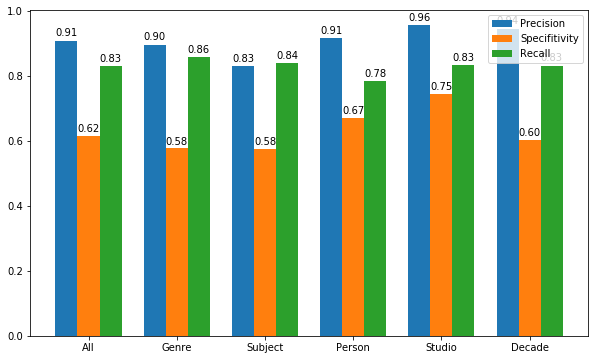

In [59]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

precisions = [metric[0] for metric in results.values()]
recalls = [metric[1] for metric in results.values()]
true_negative_rates = [metric[2] for metric in results.values()]

width = .25
labels = list(results.keys())
x = np.arange(len(labels))
rects1 = ax.bar(x - width, precisions, width, label='Precision')
rects2 = ax.bar(x, true_negative_rates, width, label='Specifitivity')
rects3 = ax.bar(x + width, recalls, width, label='Recall')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., 1.01*h, f'{h:.2f}',
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.savefig('metrics.png')
plt.show()

In [62]:
print(len(mr[mr.sentiment == 1]) / len(mr) * 100)

71.86470078057242
